In [1]:
import torch
print(torch.cuda.is_available())

True


In [2]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
import numpy as np 
import pandas as pd 
import os


for dirname, _, filenames in os.walk(r'C:\Users\User\anaconda3\envs\Data\Jute_Pest_Dataset\Jute_Pest_Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\User\anaconda3\envs\Data\Jute_Pest_Dataset\Jute_Pest_Dataset\test\Beet Armyworm\image-49-_jpg.rf.bea68748bdba49337aa703c27ddcfed4.jpg
C:\Users\User\anaconda3\envs\Data\Jute_Pest_Dataset\Jute_Pest_Dataset\test\Beet Armyworm\image-50-_jpg.rf.5c130069a237d7301558c99670157bef.jpg
C:\Users\User\anaconda3\envs\Data\Jute_Pest_Dataset\Jute_Pest_Dataset\test\Beet Armyworm\image-51-_jpg.rf.411f58b1ca9c13f8514dfdd95ca6af9f.jpg
C:\Users\User\anaconda3\envs\Data\Jute_Pest_Dataset\Jute_Pest_Dataset\test\Beet Armyworm\image-53-_jpg.rf.2e342d51d5f013313062ec34635cd3dc.jpg
C:\Users\User\anaconda3\envs\Data\Jute_Pest_Dataset\Jute_Pest_Dataset\test\Beet Armyworm\image-54-_jpg.rf.51b43f10cf1fcece1b5999ac2fbfd5ff.jpg
C:\Users\User\anaconda3\envs\Data\Jute_Pest_Dataset\Jute_Pest_Dataset\test\Beet Armyworm\image-55-_jpg.rf.09c9dafcad3875136915351c0527e31e.jpg
C:\Users\User\anaconda3\envs\Data\Jute_Pest_Dataset\Jute_Pest_Dataset\test\Beet Armyworm\image-57-_jpg.rf.415c60ccf2a25a84e9ac813a215f106e.jpg

In [4]:
# PyTorch and related library imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from PIL import Image

import os, pathlib, math, cv2, shutil
from tqdm import tqdm

# For data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For splitting the dataset
from sklearn.model_selection import train_test_split


In [5]:
# Adjust display options
pd.set_option('display.max_colwidth', None) # show complete value of a columns
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all rows

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np  # Ensure numpy is imported for sampling
from tqdm import tqdm

# Specify the directories where the training, validation, and testing images are stored
training = r'C:\Users\User\anaconda3\envs\Data\Jute_Pest_Dataset\Jute_Pest_Dataset\train'
validation = r'C:\Users\User\anaconda3\envs\Data\Jute_Pest_Dataset\Jute_Pest_Dataset\val'
testing = r'C:\Users\User\anaconda3\envs\Data\Jute_Pest_Dataset\Jute_Pest_Dataset\test'

# Adjusted function to process images, ensuring distribution and returning the required info
def make_dataframes(sdir, data_type='Training', max_samples=None):
    bad_images = []  # Track paths of unreadable or unsupported images
    good_ext = ['jpg', 'jpeg', 'png', 'tiff']  # Supported image file extensions
    class_samples = {}  # Store filepaths and labels by class
    
    # Get and sort class directories
    classes = sorted(os.listdir(sdir))
    for klass in classes:
        class_samples[klass] = {'filepaths': [], 'labels': []}  # Init dict for each class
        classpath = os.path.join(sdir, klass)  # Path to class directory
        flist = sorted(os.listdir(classpath))  # Sort files in class directory
        desc = f'{data_type} {klass:30s}'  # Progress bar description
        
        for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
            fpath = os.path.join(classpath, f)  # Full file path
            fl = f.lower()  # Filename in lowercase to check extension
            index = fl.rfind('.')
            ext = fl[index + 1:]  # File extension
            if ext in good_ext:
                try:
                    img = cv2.imread(fpath)  # Attempt to read image
                    class_samples[klass]['filepaths'].append(fpath)
                    class_samples[klass]['labels'].append(klass)
                except Exception as e:
                    bad_images.append(fpath)  # Log unreadable files
                    print('defective image file: ', fpath, '\nError:', e)
            else:
                bad_images.append(fpath)  # Log unsupported files

    all_filepaths, all_labels = process_class_samples(class_samples, max_samples)

    # Create pandas DataFrame
    df = pd.DataFrame({'filepaths': all_filepaths, 'labels': all_labels})
    class_count = df['labels'].nunique()  # Number of unique classes

    print_dataset_statistics(df, data_type)

    return df, classes, class_count  # Return DataFrame, classes list, and class count

def process_class_samples(class_samples, max_samples):
    all_filepaths = []
    all_labels = []
    for klass, data in class_samples.items():
        filepaths = data['filepaths']
        labels = data['labels']
        # Sample images if more than max_samples
        if max_samples is not None and len(filepaths) > max_samples:
            sample_indexes = np.random.choice(len(filepaths), max_samples, replace=False)
            for index in sample_indexes:
                all_filepaths.append(filepaths[index])
                all_labels.append(labels[index])
        else:
            all_filepaths += filepaths
            all_labels += labels
    return all_filepaths, all_labels

def print_dataset_statistics(df, data_type):
    class_count = df['labels'].nunique()
    print(f'Number of classes in {data_type} dataset = {class_count}')
    counts = df['labels'].value_counts()
    print(f'The maximum files in any class in {data_type} df is {counts.max()}')
    print(f'The minimum files in any class in {data_type} df is {counts.min()}')
    print(f'{data_type} df length = {len(df)}')

# Example usage:
np.random.seed(42)  # For reproducibility
train_df, train_classes, train_class_count = make_dataframes(training, 'Training', int(500/17))
validation_df, validation_classes, validation_class_count = make_dataframes(validation, 'Validation', int(200/17))
test_df, test_classes, test_class_count = make_dataframes(testing, 'Testing', int(200/17))

# Now, train_df, validation_df, and test_df contain the desired distributions,
# and you also have the classes and class_count for each dataset type.


In [ ]:
# Specify the directories where the training, validation, and testing images are stored
training = r'C:\Users\User\anaconda3\envs\Data\Jute_Pest_Dataset\Jute_Pest_Dataset\train'
validation = r'C:\Users\User\anaconda3\envs\Data\Jute_Pest_Dataset\Jute_Pest_Dataset\val'
testing = r'C:\Users\User\anaconda3\envs\Data\Jute_Pest_Dataset\Jute_Pest_Dataset\test'

# Adjusted function to process images and create DataFrames for model training/testing
def make_dataframes(sdir, data_type='Training', max_samples=None):
    bad_images = []  # List to track paths of unreadable or unsupported images
    good_ext = ['jpg', 'jpeg', 'png', 'tiff']  # List of supported image file extensions
    class_samples = {}  # Dictionary to store filepaths and labels by class
    
    # Get a list of class directories in the specified directory and sort them
    classes = sorted(os.listdir(sdir))
    for klass in classes:
        class_samples[klass] = {'filepaths': [], 'labels': []}  # Initialize dict for each class
        classpath = os.path.join(sdir, klass)  # Build path to class directory
        flist = sorted(os.listdir(classpath))  # List and sort files in class directory
        desc = f'{data_type} {klass:30s}'  # Description for progress bar
        
        for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
            fpath = os.path.join(classpath, f)  # Full path to file
            fl = f.lower()  # Convert filename to lowercase to check extension
            index = fl.rfind('.')  # Find position of file extension
            ext = fl[index + 1:]  # Extract file extension
            if ext in good_ext:  # If file extension is supported
                try:
                    img = cv2.imread(fpath)  # Try to read the image file
                    class_samples[klass]['filepaths'].append(fpath)  # Add file path to list
                    class_samples[klass]['labels'].append(klass)  # Add class label to list
                except Exception as e:
                    bad_images.append(fpath)  # Track path of unreadable files
                    print('defective image file: ', fpath, '\nError:', e)
            else:
                bad_images.append(fpath)  # Track files with unsupported extensions

    # Process class samples to achieve the desired distribution
    all_filepaths = []
    all_labels = []
    for klass, data in class_samples.items():
        filepaths = data['filepaths']
        labels = data['labels']
        # If a max_samples value is set, and the class contains more images than max_samples, sample them
        if max_samples is not None and len(filepaths) > max_samples:
            sample_indexes = np.random.choice(len(filepaths), max_samples, replace=False)  # Sample without replacement
            for index in sample_indexes:
                all_filepaths.append(filepaths[index])
                all_labels.append(labels[index])
        else:
            all_filepaths += filepaths
            all_labels += labels
    
    # Create pandas DataFrame
    df = pd.DataFrame({'filepaths': all_filepaths, 'labels': all_labels})

    # Calculate and print dataset statistics
    print_dataset_statistics(df, data_type)

    return df

def print_dataset_statistics(df, data_type):
    class_count = df['labels'].nunique()  # Count number of unique classes
    print(f'number of classes in {data_type} dataset= ', class_count)
    counts = df['labels'].value_counts()  # Count occurrences of each class
    print(f'the maximum files in any class in {data_type} df is ', counts.max())
    print(f'the minimum files in any class in {data_type} df is ', counts.min())
    print(f'{data_type} df length: ', len(df))  # Print total number of valid images

# Generate DataFrames for each dataset
train_df = make_dataframes(sdir=training, data_type='Training', max_samples=int(1000/17))
validation_df = make_dataframes(sdir=validation, data_type='Validation', max_samples=int(200/17))
test_df = make_dataframes(sdir=testing, data_type='Testing', max_samples=int(200/17))  # Test dataset takes all data points


In [6]:
# Specify the directories where the training, validation, and testing images are stored
training = r'C:\Users\User\anaconda3\envs\Data\Jute_Pest_Dataset\Jute_Pest_Dataset\train'
validation = r'C:\Users\User\anaconda3\envs\Data\Jute_Pest_Dataset\Jute_Pest_Dataset\val'
testing = r'C:\Users\User\anaconda3\envs\Data\Jute_Pest_Dataset\Jute_Pest_Dataset\test'

# Define a function to process images and create DataFrames for model training/testing
def make_dataframes(sdir, data_type='Training'):
    bad_images = []  # List to track paths of unreadable or unsupported images
    good_ext = ['jpg', 'jpeg', 'png', 'tiff']  # List of supported image file extensions
    filepaths = []  # List to store valid image file paths
    labels = []  # List to store labels/classes for each image
    
    # Get a list of class directories in the specified directory and sort them
    classes = sorted(os.listdir(sdir))
    for klass in classes:
        classpath = os.path.join(sdir, klass)  # Build path to class directory
        flist = sorted(os.listdir(classpath))  # List and sort files in class directory
        desc = f'{data_type} {klass:30s}'  # Description for progress bar
        
        # Loop through each file in the class directory with a progress bar
        for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
            fpath = os.path.join(classpath, f)  # Full path to file
            fl = f.lower()  # Convert filename to lowercase to check extension
            index = fl.rfind('.')  # Find position of file extension
            ext = fl[index + 1:]  # Extract file extension
            if ext in good_ext:  # If file extension is supported
                try:
                    img = cv2.imread(fpath)  # Try to read the image file
                    shape = img.shape  # Get image shape (unused but could be for validation)
                    filepaths.append(fpath)  # Add file path to list
                    labels.append(klass)  # Add class label to list
                except Exception as e:
                    bad_images.append(fpath)  # Track path of unreadable files
                    print('defective image file: ', fpath, '\nError:', e)
            else:
                bad_images.append(fpath)  # Track files with unsupported extensions
    
    # Create pandas Series from filepaths and labels lists
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)  # Concatenate Series to form DataFrame
    
    # Calculate and print dataset statistics
    classes = sorted(df['labels'].unique())  # Get unique classes
    class_count = len(classes)  # Count number of unique classes
    print(f'number of classes in {data_type} dataset= ', class_count)
    counts = list(df['labels'].value_counts())  # Count occurrences of each class
    print(f'the maximum files in any class in {data_type} df is ', max(counts))
    print(f'the minimum files in any class in {data_type} df is ', min(counts))
    print(f'{data_type} df length: ', len(df))  # Print total number of valid images

    return df, classes, class_count  # Return the DataFrame, list of classes, and class count

# Generate DataFrames for training, validation, and testing datasets
train_df, train_classes, train_class_count = make_dataframes(sdir=training, data_type='Training')
validation_df, validation_classes, validation_class_count = make_dataframes(sdir=validation, data_type='Validation')
test_df, test_classes, test_class_count = make_dataframes(sdir=testing, data_type='Testing')


Training Yellow Mite                   : 100%|███████████████████████████| 342/342 [00:01<00:00, 207.36file/s]


number of classes in Training dataset=  17
the maximum files in any class in Training df is  676
the minimum files in any class in Training df is  199
Training df length:  6443


Validation Yellow Mite                   : 100%|███████████████████████████| 30/30 [00:00<00:00, 229.61file/s]


number of classes in Validation dataset=  17
the maximum files in any class in Validation df is  71
the minimum files in any class in Validation df is  3
Validation df length:  413


Testing Yellow Mite                   : 100%|██████████████████████████████| 24/24 [00:00<00:00, 246.74file/s]

number of classes in Testing dataset=  17
the maximum files in any class in Testing df is  24
the minimum files in any class in Testing df is  20
Testing df length:  379


In [7]:
import os
import cv2
import pandas as pd

# Define directories for the training, validation, and testing datasets.
dirs = {
    'Training': r'C:\Users\User\anaconda3\envs\Data\Jute_Pest_Dataset\Jute_Pest_Dataset\train',
    'Validation': r'C:\Users\User\anaconda3\envs\Data\Jute_Pest_Dataset\Jute_Pest_Dataset\val',
    'Testing': r'C:\Users\User\anaconda3\envs\Data\Jute_Pest_Dataset\Jute_Pest_Dataset\test'
}

# Function to process images in a given directory and return a DataFrame with file paths, labels, and image sizes.
def make_dataframes(sdir):
    filepaths = []  # List to store the paths of the images.
    labels = []  # List to store the labels of the images.
    sizes = []  # List to store the sizes of the images.
    # Iterate through each class directory in the specified directory.
    for klass in sorted(os.listdir(sdir)):
        classpath = os.path.join(sdir, klass)  # Construct the full path to the class directory.
        # Iterate through each image file in the class directory.
        for f in sorted(os.listdir(classpath)):
            fpath = os.path.join(classpath, f)  # Construct the full path to the image file.
            img = cv2.imread(fpath)  # Read the image file.
            if img is not None:  # Check if the image was successfully read.
                shape = img.shape  # Obtain the dimensions of the image.
                filepaths.append(fpath)  # Add the image path to the list.
                labels.append(klass)  # Add the label to the list.
                sizes.append(shape)  # Add the image size to the list.
    
    # Create a DataFrame with the collected data.
    df = pd.DataFrame({
        'filepaths': filepaths,
        'labels': labels,
        'sizes': sizes
    })
    
    return df  # Return the DataFrame.

# Loop through each dataset directory to analyze the image sizes.
for data_type, path in dirs.items():
    df = make_dataframes(path)  # Process the images in the directory.
    size_counts = df['sizes'].value_counts()  # Count the occurrences of each image size.
    min_size = min(df['sizes'], key=lambda x: x[0]*x[1])  # Find the smallest image size.
    max_size = max(df['sizes'], key=lambda x: x[0]*x[1])  # Find the largest image size.
    
    # Print out a summary of the image sizes for the dataset.
    print(f"\n{data_type} Dataset:")
    print("Top 3 most common image sizes:")
    print(size_counts.head(3))  # Display the top 3 most common image sizes.
    print(f"Smallest image size: {min_size}")  # Print the smallest image size.
    print(f"Largest image size: {max_size}")  # Print the largest image size.



Training Dataset:
Top 3 most common image sizes:
sizes
(256, 256, 3)    5416
(640, 640, 3)     782
(416, 416, 3)      63
Name: count, dtype: int64
Smallest image size: (188, 250, 3)
Largest image size: (1920, 1920, 3)

Validation Dataset:
Top 3 most common image sizes:
sizes
(256, 256, 3)    133
(640, 640, 3)    131
(416, 416, 3)     13
Name: count, dtype: int64
Smallest image size: (175, 103, 3)
Largest image size: (4592, 3056, 3)

Testing Dataset:
Top 3 most common image sizes:
sizes
(256, 256, 3)    274
(640, 640, 3)     68
(416, 416, 3)     11
Name: count, dtype: int64
Smallest image size: (178, 283, 3)
Largest image size: (797, 960, 3)


In [8]:
# dimensions of train, validation, test dataset
d = [('Train', train_df), ('Validation', validation_df), ('Test', test_df)]

# Looping through the list to print the name and shape of each dataset
for name, data in d:
    print(f"{name} : {data.shape}")


Train : (6443, 2)
Validation : (413, 2)
Test : (379, 2)


### Transforming the dataset

In [9]:
# Define directories for your dataset
dataset_dir = r'C:\Users\User\anaconda3\envs\Data\Jute_Pest_Dataset\Jute_Pest_Dataset'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
testing_dir = os.path.join(dataset_dir, 'test')

# Define transformation pipeline
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images
    transforms.RandomHorizontalFlip(),  # Augmentation
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])


### Load the dataset

In [10]:
# Load datasets with ImageFolder
train_dataset = datasets.ImageFolder(root=training_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=validation_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=testing_dir, transform=transform)

# Create DataLoaders
batch_size = 32 # Number of images to be loaded per batch

In [11]:
# DataLoader for training data with shuffling to ensure random distribution of data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=batch_size) # DataLoader for validation data without shuffling
test_loader = DataLoader(test_dataset, batch_size=batch_size) # DataLoader for testing data without shuffling

### define the model

In [12]:
# Load a pre-trained DenseNet201 model
model = models.densenet201(pretrained=True)  # Command: Import DenseNet201 from torchvision and load with pre-trained weights

# Extract the number of features of the last layer
num_features = model.classifier.in_features  # Command: Access the input features of the DenseNet201 classifier to modify it

# Replace the classifier layer with a new fully connected layer
# with the number of outputs equal to the number of classes in the training dataset
model.classifier = nn.Linear(num_features, len(train_dataset.classes))  # Command: Replace the model's classifier with a new linear layer

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Command: Use CUDA if available, otherwise fallback to CPU

# Move the model to the defined device (GPU or CPU)
model.to(device)  # Command: Transfer the model to the selected device for computation efficiency



C:\Users\User\anaconda3\envs\pytorch_project_1\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\pytorch_project_1\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### loss function and optimiser

In [13]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
device

device(type='cuda', index=0)

In [15]:
num_epochs = 5  # Update number of training epochs

# Initialize lists to track per-epoch losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    # Variables to track training progress
    training_loss = 0.0
    correct_preds = 0
    total_preds = 0

    # Iterate over batches of training data
    train_bar = tqdm(train_loader, desc=f'Training Epoch {epoch + 1}/{num_epochs}')
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() # Clear gradients from the previous step
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward() # Backpropagate errors
        optimizer.step() # Update weights

        training_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

        train_bar.set_description(f"Epoch {epoch + 1}/{num_epochs} - Loss: {loss.item():.4f}, Acc: {100 * correct_preds / total_preds:.2f}%")

    # Record the average training loss and accuracy for the epoch
    train_losses.append(training_loss / len(train_loader))
    train_accuracies.append(100 * correct_preds / total_preds)

    # Validation phase
    model.eval()
    validation_loss = 0.0
    correct_preds_val = 0
    total_preds_val = 0

    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f'Validating Epoch {epoch + 1}/{num_epochs}')
        for inputs, labels in val_bar:
            # Move data to the appropriate device (CPU or GPU)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_preds_val += labels.size(0)
            correct_preds_val += (predicted == labels).sum().item()

            val_bar.set_description(f"Validation - Loss: {loss.item():.4f}, Acc: {100 * correct_preds_val / total_preds_val:.2f}%")

    # Record the average validation loss and accuracy for the epoch
    val_losses.append(validation_loss / len(val_loader))
    val_accuracies.append(100 * correct_preds_val / total_preds_val)

    # Epoch summary
    print(f"Epoch {epoch + 1}/{num_epochs} Completed. Training Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.2f}%. Validation Loss: {val_losses[-1]:.4f}, Accuracy: {val_accuracies[-1]:.2f}%")


Validation - Loss: 0.4325, Acc: 79.42%: 100%|██████████████████████████████████████████| 13/13 [00:56<00:00,  4.37s/it]


Epoch 1/5 Completed. Training Loss: 0.7748, Accuracy: 76.71%. Validation Loss: 0.9406, Accuracy: 79.42%


Validation - Loss: 0.1745, Acc: 82.57%: 100%|██████████████████████████████████████████| 13/13 [00:59<00:00,  4.54s/it]


Epoch 2/5 Completed. Training Loss: 0.3403, Accuracy: 89.70%. Validation Loss: 0.6804, Accuracy: 82.57%


Validation - Loss: 0.0137, Acc: 77.97%: 100%|██████████████████████████████████████████| 13/13 [00:57<00:00,  4.40s/it]


Epoch 3/5 Completed. Training Loss: 0.2383, Accuracy: 93.11%. Validation Loss: 0.7922, Accuracy: 77.97%


Validation - Loss: 0.0994, Acc: 78.93%: 100%|██████████████████████████████████████████| 13/13 [00:56<00:00,  4.38s/it]


Epoch 4/5 Completed. Training Loss: 0.2168, Accuracy: 93.39%. Validation Loss: 0.6885, Accuracy: 78.93%


Validation - Loss: 0.3862, Acc: 86.44%: 100%|██████████████████████████████████████████| 13/13 [00:57<00:00,  4.39s/it]

Epoch 5/5 Completed. Training Loss: 0.1298, Accuracy: 95.90%. Validation Loss: 0.5433, Accuracy: 86.44%


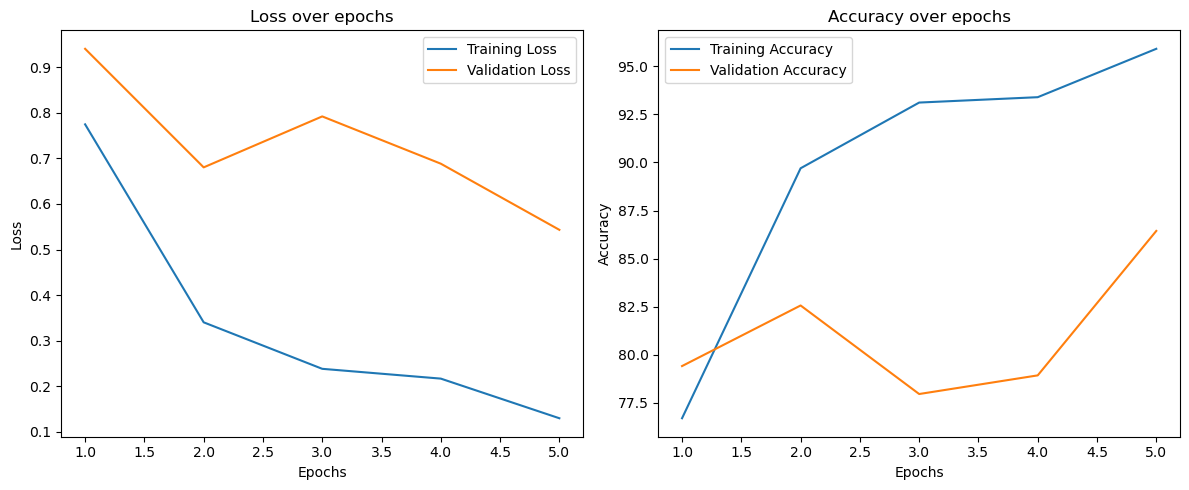

In [16]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)


In [19]:

def evaluate_model_and_collect_predictions(model, data_loader, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in tqdm(data_loader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_preds += labels.size(0)
            correct_preds += (predicted == labels).sum().item()

            # Collect predictions and true labels
            all_predictions.extend(predicted.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct_preds / total_preds
    return avg_loss, accuracy, all_labels, all_predictions

# Evaluate the model on the test data and collect predictions
test_loss, test_accuracy, true_labels, predicted_labels = evaluate_model_and_collect_predictions(model, test_loader, device)

print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.15s/it]

Test Loss: 0.1625, Accuracy: 94.99%


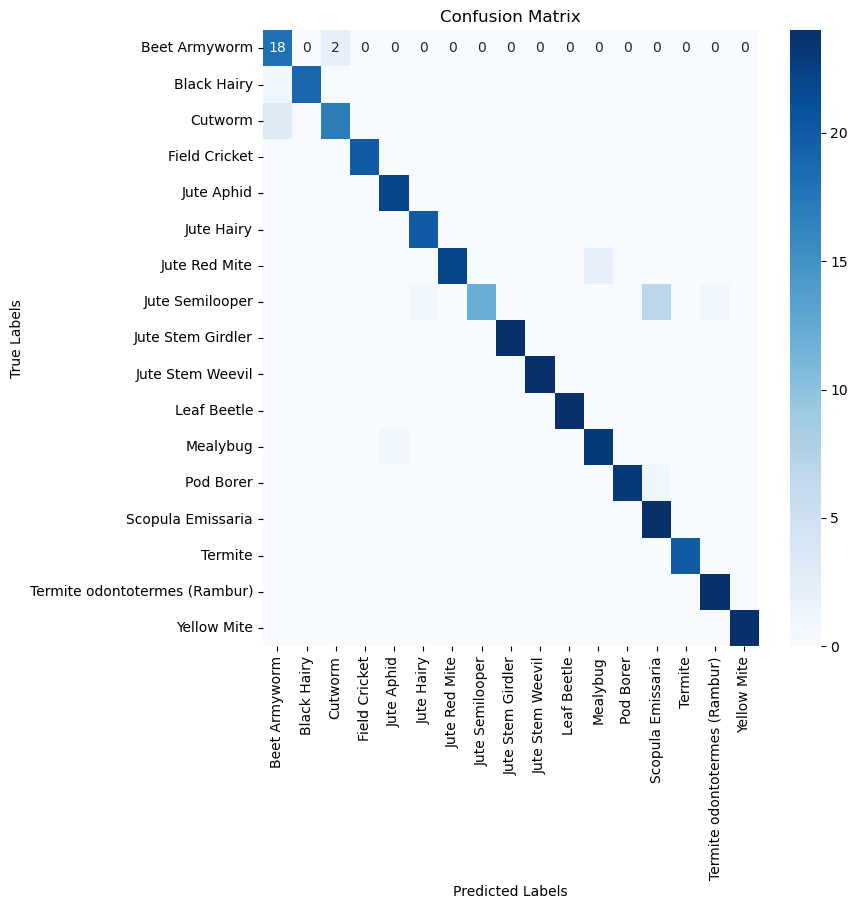

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = train_dataset.classes

def plot_confusion_matrix(labels, predictions, class_names):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


plot_confusion_matrix(true_labels, predicted_labels, class_names)


In [24]:

import pandas as pd


# Map the integer labels to class names
true_labels_names = [train_classes[label] for label in true_labels]
predicted_labels_names = [train_classes[label] for label in predicted_labels]

# Create the cross-tabulation with class names
confusion_matrix_df = pd.crosstab(pd.Series(true_labels_names, name='Actual'),
                                  pd.Series(predicted_labels_names, name='Predicted'),
                                  margins=True)

confusion_matrix_df


Predicted,Beet Armyworm,Black Hairy,Cutworm,Field Cricket,Jute Aphid,Jute Hairy,Jute Red Mite,Jute Semilooper,Jute Stem Girdler,Jute Stem Weevil,Leaf Beetle,Mealybug,Pod Borer,Scopula Emissaria,Termite,Termite odontotermes (Rambur),Yellow Mite,All
Actual,,,,,,,,,,,,,,,,,,
Beet Armyworm,18,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20
Black Hairy,1,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20
Cutworm,3,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20
Field Cricket,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,20
Jute Aphid,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,22
Jute Hairy,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,20
Jute Red Mite,0,0,0,0,0,0,22,0,0,0,0,2,0,0,0,0,0,24
Jute Semilooper,0,0,0,0,0,1,0,12,0,0,0,0,0,7,0,1,0,21
Jute Stem Girdler,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,24


In [25]:
pd.crosstab(true_labels, predicted_labels, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Predicted,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,All
Actual,,,,,,,,,,,,,,,,,,
0,18,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20
1,1,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20
2,3,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20
3,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,20
4,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,22
5,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,20
6,0,0,0,0,0,0,22,0,0,0,0,2,0,0,0,0,0,24
7,0,0,0,0,0,1,0,12,0,0,0,0,0,7,0,1,0,21
8,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,24


In [26]:
# Importing the classification_report function from scikit-learn metrics module
from sklearn.metrics import classification_report

# Generating a classification report
# true_labels: The ground truth labels for your test dataset
# predicted_labels: The labels predicted by your model
# target_names: A list of class names corresponding to the labels
report = classification_report(true_labels, predicted_labels, target_names=train_classes)

# Printing the classification report to the console
# The report includes key metrics (precision, recall, f1-score, support) for each class
# along with macro and weighted averages of these metrics across all classes
print(report)


                               precision    recall  f1-score   support

                Beet Armyworm       0.82      0.90      0.86        20
                  Black Hairy       1.00      0.95      0.97        20
                      Cutworm       0.89      0.85      0.87        20
                Field Cricket       1.00      1.00      1.00        20
                   Jute Aphid       0.96      1.00      0.98        22
                   Jute Hairy       0.95      1.00      0.98        20
                Jute Red Mite       1.00      0.92      0.96        24
              Jute Semilooper       1.00      0.57      0.73        21
            Jute Stem Girdler       1.00      1.00      1.00        24
             Jute Stem Weevil       1.00      1.00      1.00        24
                  Leaf Beetle       1.00      1.00      1.00        24
                     Mealybug       0.92      0.96      0.94        24
                    Pod Borer       1.00      0.96      0.98        24
     

In [31]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T

# Function to convert a torch.Tensor into an image in order to display it
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Assuming model, test_loader, and device are already defined
# Also, ensure that train_classes contains the list of class names

# Get a batch of test data
images, labels = next(iter(test_loader))

# Transfer to the correct device
images = images.to(device)
labels = labels.to(device)

# Make predictions
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Move the images and predictions back to the CPU for displaying them
images = images.cpu()
preds = preds.cpu()

# Plot the images in the batch, along with the corresponding labels and predictions
fig = plt.figure(figsize=(10, 8))
# Display images
for idx in range(len(images)):
    ax = fig.add_subplot(2, len(images)//2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(f"Predicted: {train_classes[preds[idx]]}\nActual: {train_classes[labels[idx]]}")

plt.show()


OutOfMemoryError: CUDA out of memory. Tried to allocate 24.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 11.18 GiB is allocated by PyTorch, and 242.16 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### CUDA out of memory. GPU is not working after this point